In [18]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import paho.mqtt.client as mqtt
from threading import Timer
import json
from config import username, password

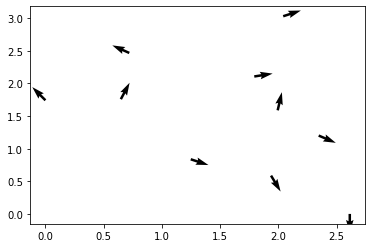

In [20]:
measured=np.array([
    [0, 37.9, 92.2, 95.2, 56.6, 95.5, 73.5, 56.7, 121.2, 73.9],
    [0, 0, 54.7, 71.8, 44.4, 59.4, 41.6, 21.9, 89.5, 46.8],
    [0, 0, 0, 60.3, 67.6, 27.3, 45.8, 42.3, 65.1, 43.5],
    [0, 0, 0, 0, 40.4, 87.1, 94.8, 78.9, 125.4, 25.4],
    [0, 0, 0, 0, 0, 86.9, 81.3, 61.5, 123.0, 28.0],
    [0, 0, 0, 0, 0, 0, 29.1, 39.1, 28.3, 67.2],
    [0, 0, 0, 0, 0, 0, 0, 20.6, 48.6, 70.0],
    [0, 0, 0, 0, 0, 0, 0, 0, 67.6, 53.5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 105.5],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
measured*=0.0254
measured+=measured.T
model = MDS(n_components=2, metric=True, dissimilarity='precomputed', random_state=1, n_init=1000, max_iter=1000)
positions = model.fit_transform(measured)
positions -= positions[8]
positions[:, 1]*=-1
theta=np.radians(221)+math.atan2(positions[5,1],positions[5,0])
positions=positions.dot([[np.cos(theta), -np.sin(theta)],
                         [np.sin(theta),  np.cos(theta)]])
positions[:,0]-=positions[3,0]
angles=np.radians([18,9,-18,135,156,-59,-23,77,-90,62])
plt.quiver(positions[:,0], positions[:,1], np.cos(angles), np.sin(angles))

In [23]:
addresses=["30:ae:a4:cc:24:6a","30:ae:a4:cc:32:4e","ac:67:b2:53:82:8a","ac:67:b2:53:7f:22","ac:67:b2:53:84:82","ac:67:b2:53:84:aa","24:0a:c4:eb:36:8a","ac:67:b2:53:93:1e","ac:67:b2:53:84:b2","ac:67:b2:53:7b:3a"]
df=pd.DataFrame(columns=("TIMESTAMP","SCANNER","ADVERTISER","TX POWER","RSSI","DISTANCE","ANGLE"))
class RepeatTimer(Timer):
    def run(self):
        while not self.finished.wait(self.interval):
            self.function(*self.args, **self.kwargs)

def switch_devices(client, devices):
    for device in devices:
        client.publish("blescan/ctrl/"+device, payload=random.choice(('scan','adv')))

def on_connect(client, userdata, flags, rc):
    client.subscribe("blescan/ibeacon/#")

def on_message(client, userdata, msg):
    source=msg.topic.rsplit('/', 1)[-1]
    json_line = json.loads(msg.payload.decode('ASCII').replace('""','"'))
    print(source,json_line,sep="\t")
    if source in addresses and json_line["Address"] in addresses:
        sc_pos=positions[addresses.index(source)]
        ad_pos=positions[addresses.index(json_line["Address"])]
        dx=sc_pos[0]-ad_pos[0]
        dy=sc_pos[1]-ad_pos[1]
        df.loc[len(df)]=[pd.Timestamp.now(),source,json_line["Address"],json_line["txPwr"],json_line["RSSI"],math.sqrt(dx**2+dy**2),(math.atan2(dy,dx)-angles[addresses.index(json_line["Address"])]+2*np.pi)%(2*np.pi)]

client=mqtt.Client("reader")
client.on_connect = on_connect
client.on_message = on_message
client.connect('mqtt.vonk', 1883)
client.username_pw_set(username=username,password=password)
timer = RepeatTimer(60, switch_devices, args=(client,addresses))
try:
    client.loop_start()
    timer.start()
except KeyboardInterrupt:
    client.loop_stop()
    timer.cancel()

In [25]:
df

,TIMESTAMP,SCANNER,ADVERTISER,TX POWER,RSSI,DISTANCE,ANGLE
